<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN_asof_071245FEB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install alpaca_trade_api

Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [100]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [101]:
random_seed = 82
torch.manual_seed(random_seed)

In [102]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [103]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [104]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2018, 10, 31)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 365
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "WMT" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 668
Number of days of Validation Data 365
Number of days of Holdout Test Data 830


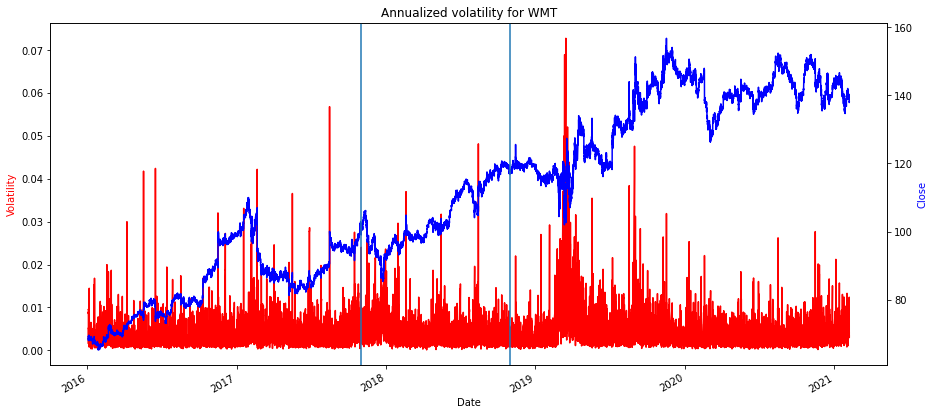

In [105]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .15, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [106]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

In [107]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .25, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  returns = np.log(target_close_df['Close']/(target_close_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)
  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * volatility)), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * volatility)), 
           0, targets)

  return targets

In [108]:
volity_val = 10
y_train_pre_final = buildTargets(X_train_pre_final, volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, volity_int = volity_val)

In [109]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

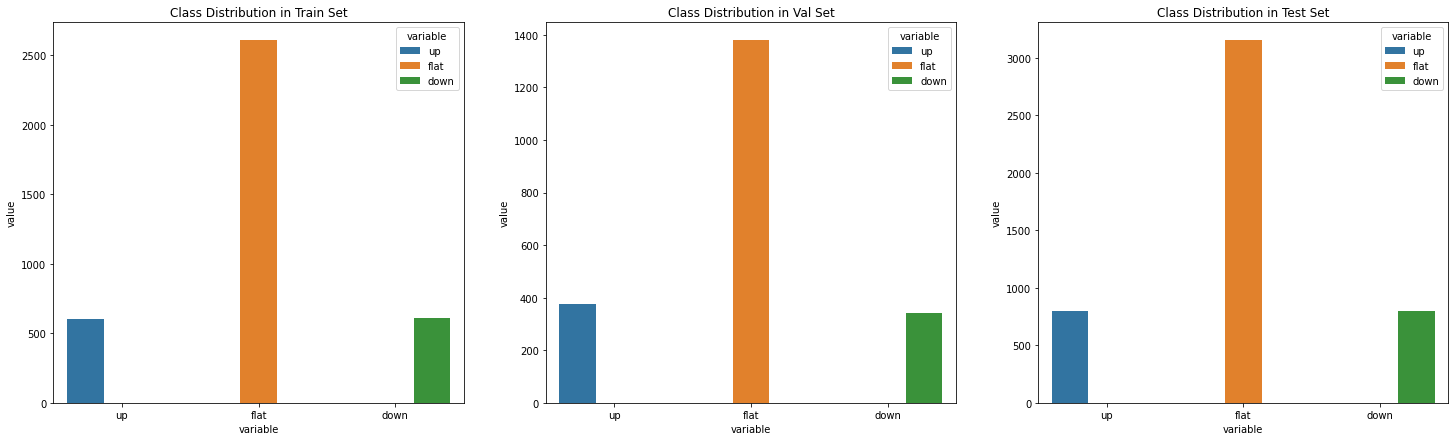

In [110]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [133]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [145]:
X_train[0]

array([[-1.51836679, -1.5611663 , -1.61033518, -1.60032457, -1.60228808,
        -1.60860507, -1.60315545, -1.60702411, -1.62077708, -1.61897301,
        -1.62331886, -1.61273107, -1.60219153, -1.59798771, -1.59792279,
        -1.58811137, -1.58670937, -1.58804876, -1.5859888 , -1.58759911,
        -1.58644097, -1.59143589, -1.58943678, -1.59849783],
       [-1.52498251, -1.56323599, -1.60491986, -1.59941605, -1.60074906,
        -1.60017803, -1.60486046, -1.60947734, -1.61807661, -1.62169494,
        -1.60794683, -1.60392709, -1.59798289, -1.59774024, -1.58927559,
        -1.58749818, -1.5838256 , -1.58682966, -1.58336495, -1.5885018 ,
        -1.5883848 , -1.59304314, -1.59021987, -1.59998646],
       [-1.57677416, -1.60809115, -1.62400001, -1.60425407, -1.61076981,
        -1.6079021 , -1.60589758, -1.62102748, -1.62179972, -1.62586077,
        -1.62030767, -1.60954166, -1.60659793, -1.59784551, -1.59568522,
        -1.58954566, -1.58564394, -1.58656132, -1.58558496, -1.58920003,
  

In [147]:
######
# Code fro scaling at a later date
######

from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
    
for i in range(X_val.shape[1]):
    X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    

In [148]:
X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [114]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (2385, 1, 5, 24), y Train Label Length (2385,)
X Val Length (1310, 1, 5, 24), y Val Label Length (1310,)
X Test Length (2965, 1, 5, 24), y Test Label Length (2965,)


# Build Model

In [149]:
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(y_train).long())
valset = TensorDataset(torch.from_numpy(X_val).float(), 
                        torch.from_numpy(y_val).long())

In [150]:
batch_size = 12

# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(train_loader))
print(i1.shape)

# val_data = []
# for i in range(len(X_val)):
#    val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(val_loader))
print(i1.shape)

torch.Size([12, 1, 5, 24])
torch.Size([12, 1, 5, 24])


In [151]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows.shape)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    print(labels[idx])

torch.Size([12, 1, 5, 24])
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(0)
tensor(2)
tensor(2)


<Figure size 1080x360 with 0 Axes>

In [152]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(trainset),'val':len(valset)}
# Get class names associated with labels
classes = [0,1,2]

In [224]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d(4,4)
    self.batchNorm1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d(3,3) 
    self.batchNorm2 = nn.BatchNorm2d(64) 

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d(2,2)
    self.batchNorm3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128,1000) #calculate this
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 3)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):

    x = F.relu(self.dropout(self.conv1(x)))
    x = self.pool1(x)
    #x = self.batchNorm1(x)
    x = F.relu(self.dropout(self.conv2(x)))
    x = self.pool2(x)
    #x = self.batchNorm2(x)
    x = F.relu(self.dropout(self.conv3(x)))
    x = self.pool3(x)
    #x = self.batchNorm3(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    output = x # F.softmax(x, dim=0)

    return output


In [225]:
# Instantiate the model
model = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(model,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [12, 32, 7, 24]             128
           Dropout-2            [12, 32, 7, 24]               0
         MaxPool2d-3             [12, 32, 1, 6]               0
            Conv2d-4             [12, 64, 3, 6]           6,208
           Dropout-5             [12, 64, 3, 6]               0
         MaxPool2d-6             [12, 64, 1, 2]               0
            Conv2d-7            [12, 128, 3, 2]          24,704
           Dropout-8            [12, 128, 3, 2]               0
         MaxPool2d-9            [12, 128, 1, 1]               0
           Linear-10                 [12, 1000]         129,000
           Linear-11                  [12, 500]         500,500
           Linear-12                    [12, 3]           1,503
Total params: 662,043
Trainable params: 662,043
Non-trainable params: 0
-------------------------------

In [226]:
def train_model(model, criterion, optimizer, train_loaders, device, num_epochs=50): #, scheduler=onecycle_scheduler):

    model = model.to(device) # Send model to GPU if available

    writer = SummaryWriter() # Instantiate TensorBoard

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

                # Write loss for batch to TensorBoard
                writer.add_scalar("{} / batch loss".format(phase), loss.item(), iter_num[phase])

                # scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Write loss and accuracy for epoch to TensorBoard
            writer.add_scalar("{} / epoch loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{} / epoch accuracy".format(phase), epoch_acc, epoch)

    writer.close()
    
    return

In [227]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
# weights = torch.tensor([1.75, 2.25, 1.]).to(device)
# criterion_weighted = nn.CrossEntropyLoss(weight=weights)

criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00001)


n_epochs= 100 # For demo purposes.  Use epochs>100 for actual training

# onecycle_scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
#                                         max_lr=0.01,
#                                         base_momentum = 0.8,
#                                         steps_per_epoch=len(train_loader),
#                                         epochs=n_epochs)



train_model(model, criterion, optimizer, dataloaders, device, num_epochs=n_epochs) #, scheduler=onecycle_scheduler)

Epoch 0/99
----------
train Loss: 1.0925 Acc: 0.4029
val Loss: 1.0853 Acc: 0.4977
Epoch 1/99
----------
train Loss: 1.0927 Acc: 0.4159
val Loss: 1.0853 Acc: 0.4977
Epoch 2/99
----------
train Loss: 1.0923 Acc: 0.4096
val Loss: 1.0853 Acc: 0.4977
Epoch 3/99
----------
train Loss: 1.0926 Acc: 0.4109
val Loss: 1.0853 Acc: 0.4977
Epoch 4/99
----------
train Loss: 1.0923 Acc: 0.4239
val Loss: 1.0853 Acc: 0.4977
Epoch 5/99
----------
train Loss: 1.0927 Acc: 0.4201
val Loss: 1.0853 Acc: 0.4977
Epoch 6/99
----------
train Loss: 1.0926 Acc: 0.4138
val Loss: 1.0853 Acc: 0.4977
Epoch 7/99
----------
train Loss: 1.0927 Acc: 0.4117
val Loss: 1.0853 Acc: 0.4977
Epoch 8/99
----------
train Loss: 1.0923 Acc: 0.4143
val Loss: 1.0853 Acc: 0.4977
Epoch 9/99
----------
train Loss: 1.0928 Acc: 0.4096
val Loss: 1.0853 Acc: 0.4977
Epoch 10/99
----------
train Loss: 1.0929 Acc: 0.4042
val Loss: 1.0853 Acc: 0.4977
Epoch 11/99
----------
train Loss: 1.0931 Acc: 0.4109
val Loss: 1.0853 Acc: 0.4977
Epoch 12/99
--

In [231]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits, dim=0)
            #print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(3):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)

    
    return test_acc, recall_vals
  

In [232]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,val_loader,device)
classes = [0,1,2]
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(3):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.418
For class 0, recall is 0.08808290155440414
For class 1, recall is 0.40703517587939697
For class 2, recall is 0.4891067538126362


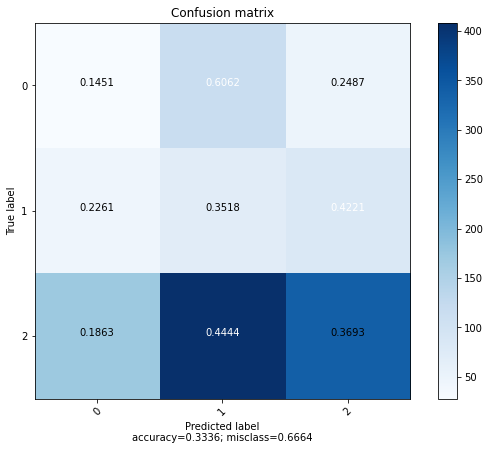

              precision    recall  f1-score   support

        down     0.1148    0.1451    0.1281       193
          up     0.1176    0.3518    0.1763       199
        flat     0.7197    0.3693    0.4881       918

    accuracy                         0.3336      1310
   macro avg     0.3174    0.2887    0.2642      1310
weighted avg     0.5391    0.3336    0.3877      1310



In [235]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        logits = model.forward(inputs)
        outputs = F.softmax(logits, dim=0)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
plot_confusion_matrix(conf_mat, [0,1,2])

from sklearn.metrics import precision_score

precision_score(lbllist.numpy(), predlist.numpy(), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=["down","up","flat"], digits=4))

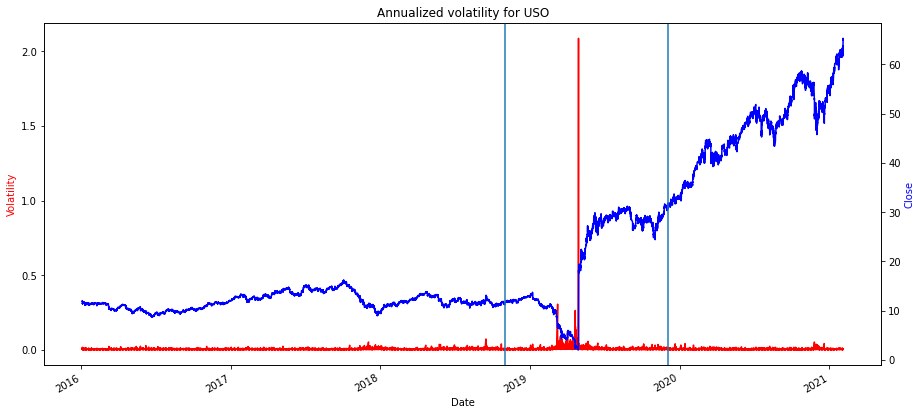

In [ ]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .15, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [ ]:
######
# Code fro scaling at a later date
######

from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [ ]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (2952, 1, 5, 24), y Train Label Length (2952,)
X Val Length (1148, 1, 5, 24), y Val Label Length (1148,)
X Test Length (1212, 1, 5, 24), y Test Label Length (1212,)


In [ ]:
X_train[0].shape

(1, 5, 24)

In [ ]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')
print("")
print('Training data window: ', len(X_train))
print('Val data windows: ', len(X_val))

X Train Length (2952, 1, 5, 24), y Train Label Length (2952,)
X Val Length (1148, 1, 5, 24), y Val Label Length (1148,)
X Test Length (1212, 1, 5, 24), y Test Label Length (1212,)

Training data window:  2952
Val data windows:  1148


In [ ]:
y_train[0].dtype

dtype('int64')

In [ ]:
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(y_train).long())
valset = TensorDataset(torch.from_numpy(X_val).float(), 
                        torch.from_numpy(y_val).long())
testset = TensorDataset(torch.from_numpy(X_test).float(), 
                        torch.from_numpy(y_test).long())

In [ ]:
batch_size = 1

# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(trainset, shuffle=False)
i1, l1 = next(iter(train_loader))
print(i1.shape)

# val_data = []
# for i in range(len(X_val)):
#    val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(valset, shuffle=False)
i1, l1 = next(iter(val_loader))
print(i1.shape)

test_loader = torch.utils.data.DataLoader(testset, shuffle=False)
i1, l1 = next(iter(test_loader))
print(i1.shape)

torch.Size([1, 1, 5, 24])
torch.Size([1, 1, 5, 24])
torch.Size([1, 1, 5, 24])


In [ ]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows.shape)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    print(labels[idx])

torch.Size([1, 1, 5, 24])
tensor(2)


<Figure size 1080x360 with 0 Axes>

In [ ]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader, 'test':test_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(trainset),'val':len(valset), 'test':len(testset)}
# Get class names associated with labels
classes = [0,1,2]

In [ ]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d(4,4)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d(3,3)  

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128,1000) 
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 3)

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    output = x#F.softmax(x, dim=1)

    return output


In [ ]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 32, 7, 24]             128
         MaxPool2d-2              [1, 32, 1, 6]               0
            Conv2d-3              [1, 64, 3, 6]           6,208
         MaxPool2d-4              [1, 64, 1, 2]               0
            Conv2d-5             [1, 128, 3, 2]          24,704
         MaxPool2d-6             [1, 128, 1, 1]               0
            Linear-7                  [1, 1000]         129,000
            Linear-8                   [1, 500]         500,500
            Linear-9                     [1, 3]           1,503
Total params: 662,043
Trainable params: 662,043
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 2.53
Estimated Total Size (MB): 2.60
-------------------------------------------

In [ ]:
def train_model(model, criterion, optimizer, train_loaders, device, num_epochs=50):

    model = model.to(device) # Send model to GPU if available

    writer = SummaryWriter() # Instantiate TensorBoard

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

                # Write loss for batch to TensorBoard
                writer.add_scalar("{} / batch loss".format(phase), loss.item(), iter_num[phase])

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Write loss and accuracy for epoch to TensorBoard
            writer.add_scalar("{} / epoch loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{} / epoch accuracy".format(phase), epoch_acc, epoch)

    writer.close()
    
    return

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
weights = torch.tensor([2., 3., 1.]).to(device)
criterion_weighted = nn.CrossEntropyLoss(weight=weights)

criterion = nn.CrossEntropyLoss()

# Define optimizer
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.001)

n_epochs= 25 # For demo purposes.  Use epochs>100 for actual training

# onecycle_scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
#                                         max_lr=0.01,
#                                         base_momentum = 0.8,
#                                         steps_per_epoch=len(train_loader),
#                                         epochs=n_epochs)


# Launch TensorBoard to visualize model performance during training cycle
%load_ext tensorboard 

train_model(net, criterion_weighted, optimizer, dataloaders, device, num_epochs=n_epochs)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 0/24
----------
train Loss: 1.0481 Acc: 0.4864
val Loss: 1.0598 Acc: 0.4669
Epoch 1/24
----------
train Loss: 1.0480 Acc: 0.4864
val Loss: 1.0598 Acc: 0.4669
Epoch 2/24
----------


KeyboardInterrupt: ignored

In [ ]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.log_softmax(logits, dim=1)
            #print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(3):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [ ]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,val_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(3):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.467
For class 0, recall is 0.0
For class 1, recall is 0.0
For class 2, recall is 1.0


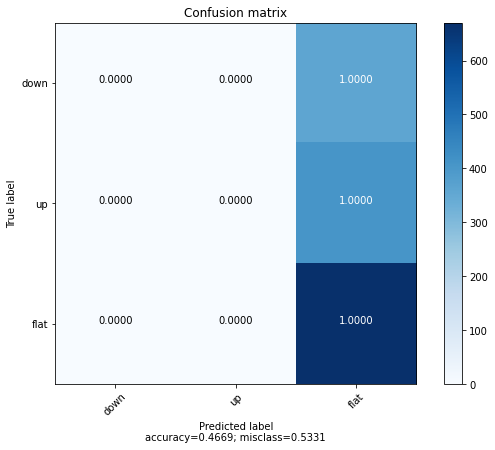

              precision    recall  f1-score   support

        down     0.0000    0.0000    0.0000       359
          up     0.0000    0.0000    0.0000       406
        flat     0.4669    1.0000    0.6366       670

    accuracy                         0.4669      1435
   macro avg     0.1556    0.3333    0.2122      1435
weighted avg     0.2180    0.4669    0.2972      1435



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 9

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net.forward(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(conf_mat, ["down", "up", "flat"])

from sklearn.metrics import classification_report

print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=["down", "up", "flat"], digits=4))

In [ ]:
# def train_model(model,criterion,optimizer,train_loader,n_epochs,device,lrscheduler=onecycle_scheduler):
    
#     loss_over_time = [] # to track the loss as the network trains
    
#     model = model.to(device) # Send model to GPU if available
#     model.train() # Set the model to training mode
    
#     for epoch in range(n_epochs):  # loop over the dataset multiple times
        
#         running_loss = 0.0
        
#         for i, data in enumerate(train_loader):
            
#           # Get the input images and labels, and send to GPU if available
#           inputs, labels = data[0].to(device), data[1].to(device)

#           # Zero the weight gradients
#           optimizer.zero_grad()

#           # Forward pass to get outputs
#           outputs = model(inputs)

#           # Calculate the loss
#           loss = criterion(outputs, labels)

#           # Backpropagation to get the gradients with respect to each weight
#           loss.backward()

#           # Update the weights
#           optimizer.step()

#           # Convert loss into a scalar and add it to running_loss
#           running_loss += loss.item()

#           running_corrects += torch.sum(preds == labels.data)
          
#           if i % 1000 == 999:    # print every 1000 batches
#               avg_loss = running_loss/1000
#               # record and print the avg loss over the 1000 batches
#               loss_over_time.append(avg_loss)
#               epoch_acc = running_corrects.double() / dataset_sizes[phase]
#               print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
#               running_loss = 0.0
          
#         # If decaying LR schedule is used, take step every epoch
#         if type(lrscheduler) == optim.lr_scheduler.StepLR:
#             lrscheduler.step()

#     return loss_over_time

Epoch: 1, Batch: 1000, Avg. Loss: 0.9958
Epoch: 1, Batch: 2000, Avg. Loss: 0.9377
Epoch: 2, Batch: 1000, Avg. Loss: 0.9122
Epoch: 2, Batch: 2000, Avg. Loss: 0.9345
Epoch: 3, Batch: 1000, Avg. Loss: 0.9121
Epoch: 3, Batch: 2000, Avg. Loss: 0.9345
Epoch: 4, Batch: 1000, Avg. Loss: 0.9121
Epoch: 4, Batch: 2000, Avg. Loss: 0.9344
Epoch: 5, Batch: 1000, Avg. Loss: 0.9120
Epoch: 5, Batch: 2000, Avg. Loss: 0.9344
Epoch: 6, Batch: 1000, Avg. Loss: 0.9120
Epoch: 6, Batch: 2000, Avg. Loss: 0.9343
Epoch: 7, Batch: 1000, Avg. Loss: 0.9120
Epoch: 7, Batch: 2000, Avg. Loss: 0.9343
Epoch: 8, Batch: 1000, Avg. Loss: 0.9120
Epoch: 8, Batch: 2000, Avg. Loss: 0.9343
Epoch: 9, Batch: 1000, Avg. Loss: 0.9120
Epoch: 9, Batch: 2000, Avg. Loss: 0.9342
Epoch: 10, Batch: 1000, Avg. Loss: 0.9120
Epoch: 10, Batch: 2000, Avg. Loss: 0.9342
Epoch: 11, Batch: 1000, Avg. Loss: 0.9120
Epoch: 11, Batch: 2000, Avg. Loss: 0.9342
Epoch: 12, Batch: 1000, Avg. Loss: 0.9120
Epoch: 12, Batch: 2000, Avg. Loss: 0.9342
Epoch: 13,

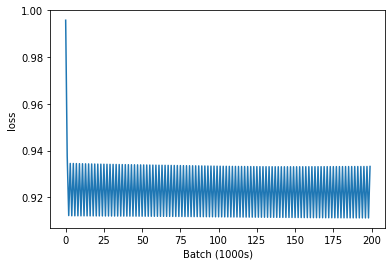

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_path = train_model(net.float(), criterion, optimizer, train_loader, n_epochs, device, lrscheduler=onecycle_scheduler)

# visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [ ]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.log_softmax(logits, dim=1)
            #print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(3):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [ ]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,val_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(3):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.632
For class 0, recall is 0.0
For class 1, recall is 0.0
For class 2, recall is 1.0


# Working Code

# Loading and Preparing The Data

# Mulitclass Classification (None CDT 1D CNN)

In [ ]:
full.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'VolumeWeightedAvgPrice'],
      dtype='object')

In [ ]:
full["Open"]

timestamp
2016-04-25 10:30:00-04:00     68.81
2016-04-25 10:35:00-04:00     68.88
2016-04-25 10:40:00-04:00     68.91
2016-04-25 10:45:00-04:00     68.90
2016-04-25 10:50:00-04:00     68.94
                              ...  
2021-01-19 08:50:00-05:00    145.00
2021-01-19 09:00:00-05:00    144.98
2021-01-19 09:10:00-05:00    144.98
2021-01-19 09:15:00-05:00    144.93
2021-01-19 09:20:00-05:00    144.81
Name: Open, Length: 124174, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [ ]:
train_targets_df = pd.DataFrame(train_targets)
val_targets_df = pd.DataFrame(val_targets)
test_targets_df = pd.DataFrame(test_targets)

class2idx = {
    "up":0,
    "flat":1,
    "down":2,
}

idx2class = {v: k for k, v in class2idx.items()}

train_targets_df.replace(class2idx, inplace=True)
val_targets_df.replace(class2idx, inplace=True)
test_targets_df.replace(class2idx, inplace=True)

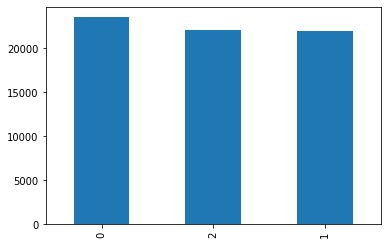

In [ ]:
train_targets_df[0].value_counts().plot(kind = 'bar')

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
  
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0


  model.train()
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
      
      
  # VALIDATION    
  with torch.no_grad():
      
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                            

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.03773 | Val Loss: 18.28548 | Train Acc: 46.339| Val Acc: 35.978
Epoch 002: | Train Loss: 1.03568 | Val Loss: 14.71919 | Train Acc: 46.572| Val Acc: 35.846
Epoch 003: | Train Loss: 1.03342 | Val Loss: 16.51808 | Train Acc: 46.793| Val Acc: 36.061
Epoch 004: | Train Loss: 1.03213 | Val Loss: 21.83980 | Train Acc: 46.823| Val Acc: 36.041
Epoch 005: | Train Loss: 1.03002 | Val Loss: 22.58325 | Train Acc: 47.167| Val Acc: 35.862
Epoch 006: | Train Loss: 1.02964 | Val Loss: 22.80922 | Train Acc: 47.228| Val Acc: 35.958
Epoch 007: | Train Loss: 1.02630 | Val Loss: 22.72420 | Train Acc: 47.528| Val Acc: 35.934
Epoch 008: | Train Loss: 1.02479 | Val Loss: 22.38807 | Train Acc: 47.576| Val Acc: 35.902
Epoch 009: | Train Loss: 1.02515 | Val Loss: 22.53223 | Train Acc: 47.479| Val Acc: 36.077
Epoch 010: | Train Loss: 1.02227 | Val Loss: 23.79687 | Train Acc: 47.802| Val Acc: 35.974
Epoch 011: | Train Loss: 1.02061 | Val Loss: 24.85404 | Train Acc: 47.934| Val Acc: 35.866

KeyboardInterrupt: ignored

# APPENDIX

In [ ]:
def OLD_timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
  Time Frame: 0730-1730
  Backfilling NaNs
  Adjusting Volume to Zero if no Trading data is present
     - Assumption is that there were no trades duing that time  
  """
  
  df = df.between_time('07:29','17:26')

  TZ = 'US/Eastern'

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time', 
                              direction='backward').set_index("Time").between_time('08:29','16:29')


  
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v


  filtered_df["Volume"] = volumeset_list
  adjvolumeset_list = []

  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)
  

def buildOutData_TorchPrep(train_df = train, val_df = val, test_df = test):
  pass

In [ ]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])

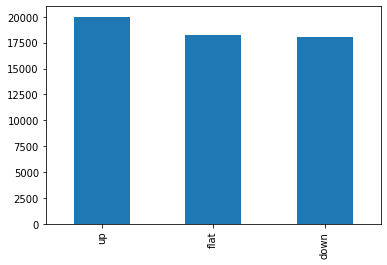

In [ ]:
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

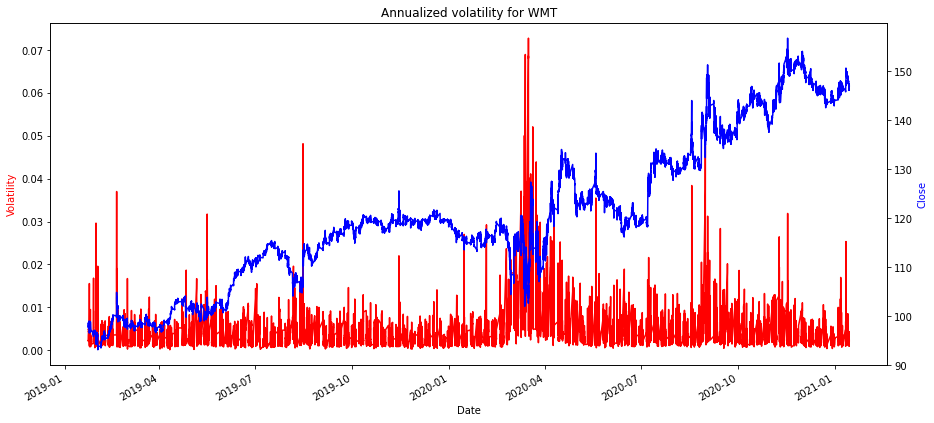

In [ ]:
def buildTargets_VolOnly(full_df = full, train_observations = train.shape[0], 
                         val_observations = val.shape[0], 
                         test_observations = test.shape[0], 
                         alph = 0.55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
plt.show()

In [ ]:
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
full.drop(columns=['Time', ])

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data=load_breast_cancer(as_frame=True)

In [ ]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64